In [1]:
# pip install xarray-spatial

In [2]:
import os
import numpy as np
from GeoDS import utilities
import rasterio
from matplotlib import pyplot as plt
import glob

plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

In [2]:
def geotiff_to_hist(FullPath, bins=10, masked=True, title='Histogram', figure_size=None, **kwargs):

    from matplotlib.patches import Rectangle
    from rasterio.io import DatasetReader    

    """Display a histogram of the given geotiff with percentile
    
    Parameters
    ----------
    source : array or dataset object opened in 'r' mode or Band or tuple(dataset, bidx)
        Input data to display.
        The first three arrays in multi-dimensional
        arrays are plotted as red, green, and blue.
    bins : int, optional
        Compute histogram across N bins.
    masked : bool, optional
        When working with a `rasterio.Band()` object, specifies if the data
        should be masked on read.
    title : str, optional
        Title for the figure.
    **kwargs : optional matplotlib keyword arguments
    
    Examples
    ----------
    output_directory = "./"
    tif_file = "Magnetics_100m_regional_RTP_UC100.tif"
    FullPath = os.path.join(output_directory, tif_file)
    utilities.geotiff_to_hist(FullPath, bins = 20, title=tif_file, figure_size=(10,8), masked=False)
    #utilities.geotiff_to_hist(FullPath, bins = 20, title=tif_file, figure_size=(10,8))
    #utilities.geotiff_to_hist(FullPath, bins = 20, title=tif_file)
    
    """

    source = rasterio.open(FullPath)

    if isinstance(source, DatasetReader):
        arr = source.read(masked=masked)
    elif isinstance(source, (tuple, rasterio.Band)):
        arr = source[0].read(source[1], masked=masked)
    else:
        arr = source

    # The histogram is computed individually for each 'band' in the array
    # so we need the overall min/max to constrain the plot
    rng = np.nanmin(arr), np.nanmax(arr)

    if len(arr.shape) == 2:
        arr = np.expand_dims(arr.flatten(), 0).T
        colors = ['gold']
    else:
        arr = arr.reshape(arr.shape[0], -1).T
        colors = ['red', 'green', 'blue', 'violet', 'gold', 'saddlebrown']

    # The goal is to provide a curated set of colors for working with
    # smaller datasets and let matplotlib define additional colors when
    # working with larger datasets.
    if arr.shape[-1] > len(colors):
        n = arr.shape[-1] - len(colors)
        colors.extend(np.ndarray.tolist(plt.get_cmap('Accent')(np.linspace(0, 1, n))))
    else:
        colors = colors[:arr.shape[-1]]


    # If a rasterio.Band() is given make sure the proper index is displayed
    # in the legend.
    if isinstance(source, (tuple, rasterio.Band)):
        labels = [str(source[1])]
    else:
        labels = (str(i + 1) for i in range(len(arr)))

    ax = plt.gca()
    fig = ax.get_figure()

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    counts, bins, patches = ax.hist(arr,
                            bins=bins,
                            color=colors,
                            label=labels,
                            range=rng,
                            facecolor=perc_50_colour,
                            edgecolor='gray',
                            **kwargs)
    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(arr, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1]

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    ax.legend(handles, labels, bbox_to_anchor=(0.7, 0., 0.30, 0.59))

    ax.set_title(title, fontweight='bold', y=-0.01)
    ax.grid(True)
    ax.set_xlabel('DN')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.set_ylim([1e0, ax.get_yticks()[-1]])

    dirname = os.path.dirname(FullPath)
    filename = os.path.basename(FullPath).split('.')[0] + '.png'

    if figure_size == None:
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
        plt.rcParams["figure.figsize"] = (figure_size[0], figure_size[1])    

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(dirname, filename))  

    return fig, ax

IPL_RTP_GPM_win.tif


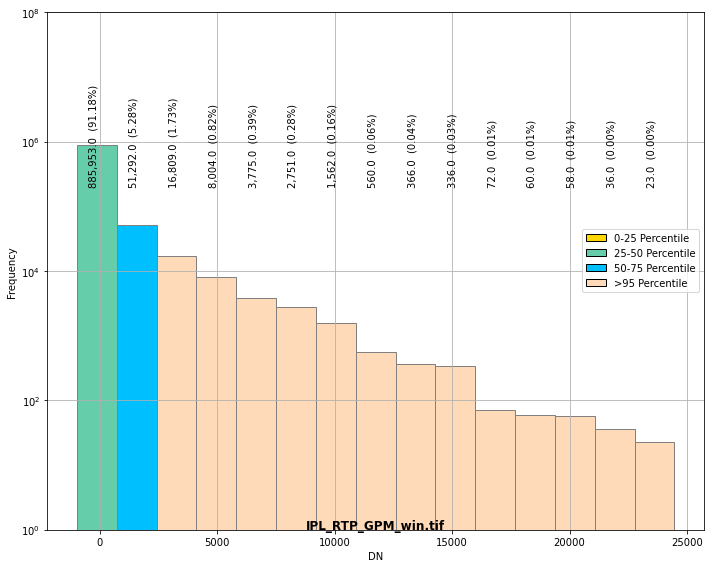

IPL_DEM_GPM_win.tif


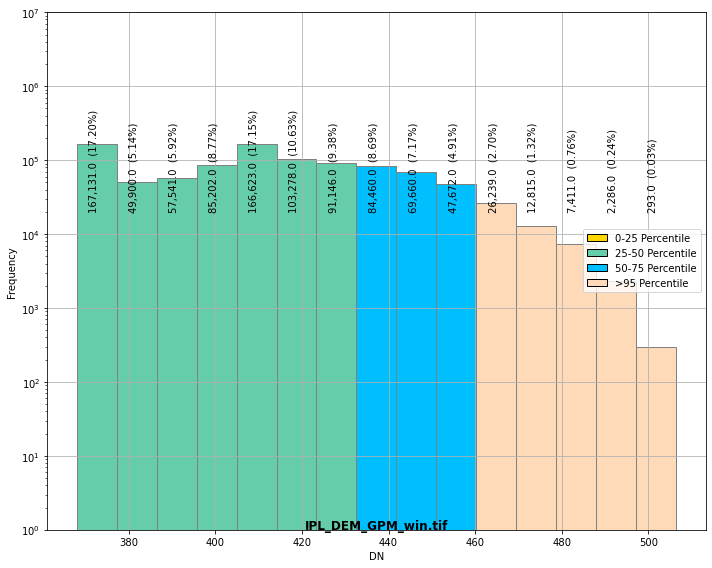

IPL_RTP_VD2_GPM_win.tif


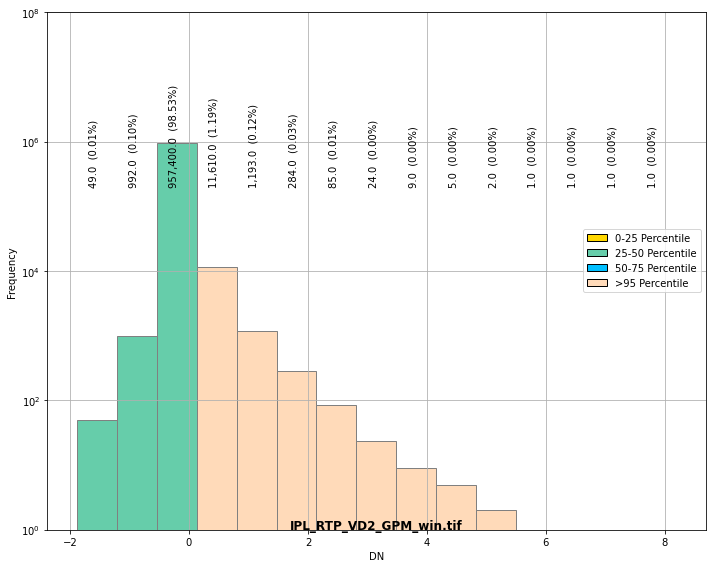

IPL_RTP_AS_GPM_win.tif


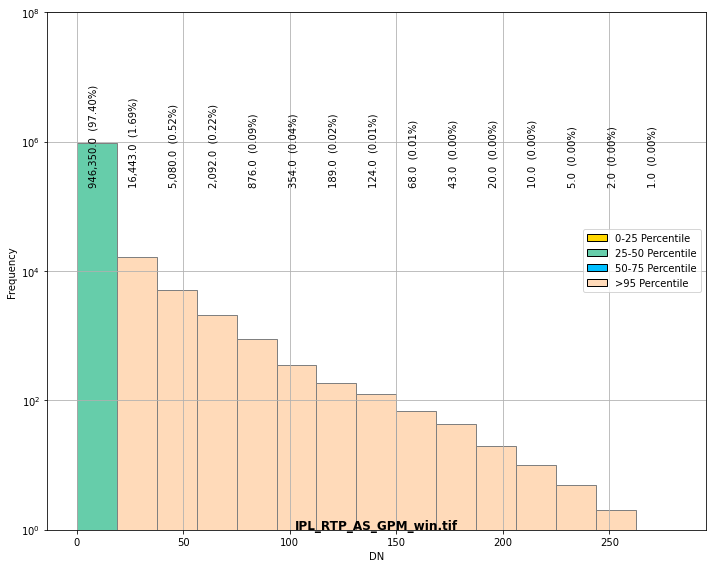

IPL_RTP_HD_GPM_win.tif


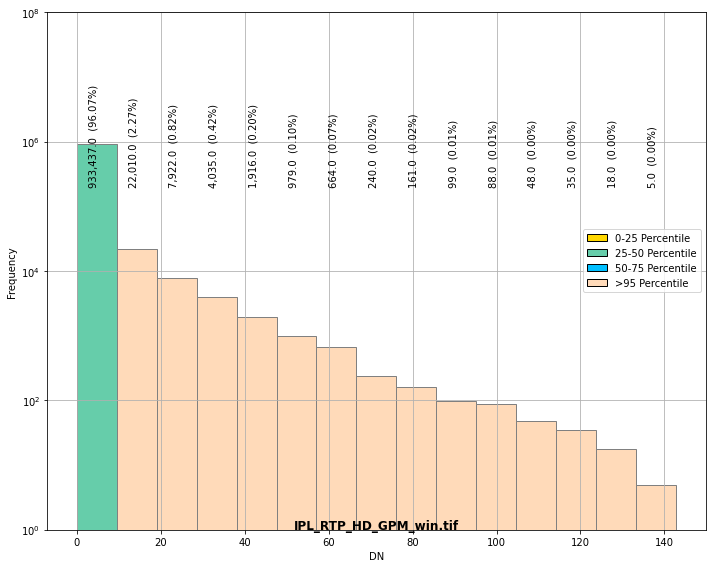

IPL_RTP_VD1_GPM_win.tif


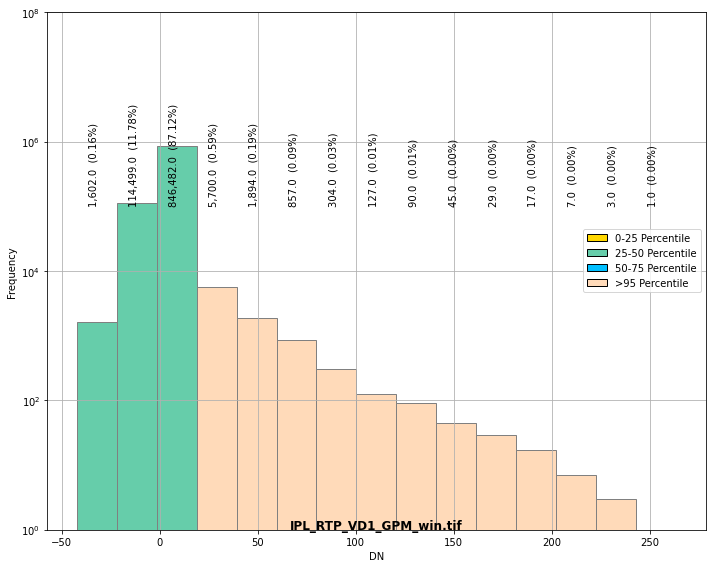

IPL_RTP_tilt_GPM_win.tif


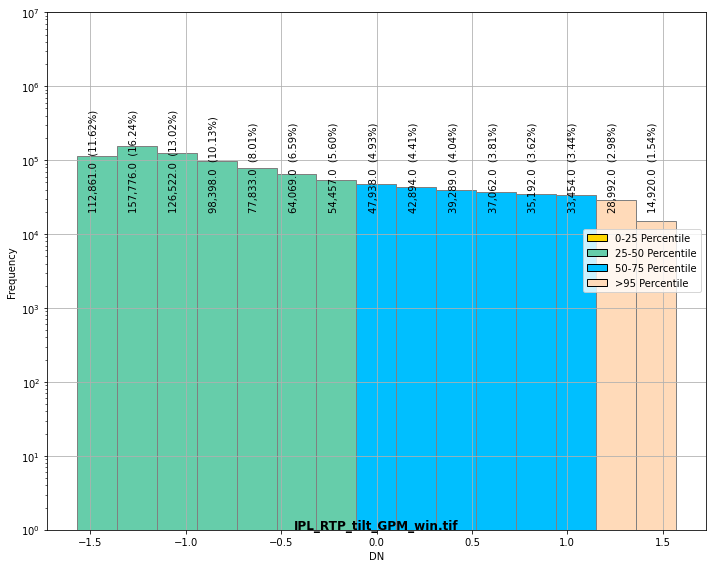

IPL_RTP_grav_GPM_win.tif


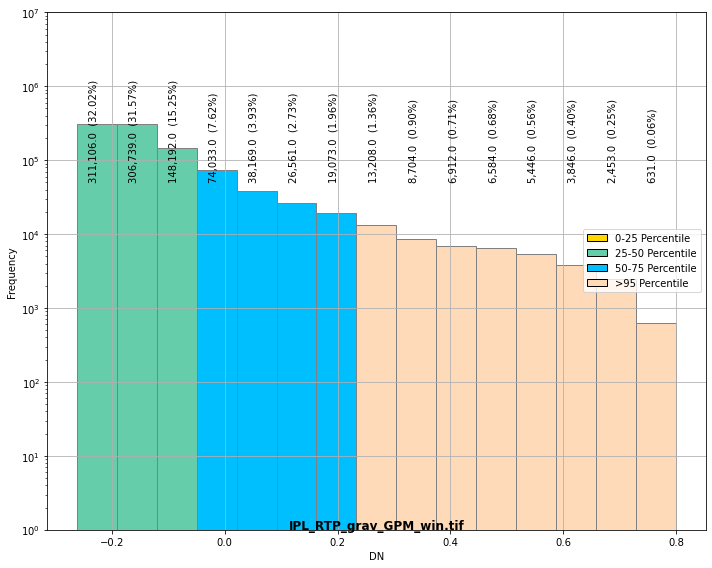

In [4]:
tif_directory = os.path.join('06_Geophysics_tifs')

if not os.path.exists(tif_directory):
    os.makedirs(tif_directory) 

tifs = glob.glob(os.path.join(tif_directory, '*.tif'))

for t in tifs:
    basename = os.path.basename(t)
    print(basename)
    geotiff_to_hist(t, bins = 15, title=basename, figure_size=(10,8))

In [13]:
from GeoDS.featureengineering import feature_extraction as feat_ext

import rioxarray as rio

In [14]:
def _geotiff_to_xarray(input_geotiff):
    xds = rio.open_rasterio(input_geotiff)
    # WE ARE ASSUMING THIS IS A SINGLE BAND XARRAY OTHERWISE WE MAY HAVE ISSUES
    name = input_geotiff.replace('.tif', '')
    df = xds.to_dataframe(name=name)

    nodata_val = xds._FillValue
    if (nodata_val != None):
        df = df.replace(nodata_val, np.nan)

    df = df.dropna(how='any')
    df.reset_index(inplace=True)
    df = df.drop(columns=['band', 'spatial_ref'])
    # columns=[name]

    df = df.set_index(['x', 'y'])
    df.dropna(how='any', inplace=True)

    xr = df.to_xarray()
    xr = xr.rio.set_spatial_dims('x', 'y')

    dstCRS = xds.rio.crs
    try:
        xr = xr.rio.write_crs(dstCRS)
    except KeyError:
        print("The provided CRS cannot be used by xarray. Check the spelling")

    xr = xr.transpose('y', 'x')
    return xr


In [46]:
def _csv_to_xarray(input_csv, columns, x_field, y_field, dstCRS):
    try:
        cols = columns.copy()
        cols.append(x_field)
        cols.append(y_field)

        data = pd.read_csv(input_csv, usecols=cols)
    except FileNotFoundError:
        print("Cannot find the input csv you provided : " + input_csv)

    return _dataframe_to_xarray(data, columns, x_field, y_field, dstCRS)

In [50]:
def _dataframe_to_xarray(input_df, columns, x_field, y_field, dstCRS):
    if (x_field != None and y_field != None):
        try:
            input_df.rename(columns={x_field: 'x', y_field: 'y'}, inplace=True)
        except KeyError:
            print('x or y columns names are not found in your input data. Check x_field and y_field arguments.')

        input_df = input_df.set_index(['x', 'y'])
        input_df.dropna(how='any', inplace=True)

        xr = input_df.to_xarray()
        xr = xr.rio.set_spatial_dims('x', 'y')
        try:
            xr = xr.rio.write_crs(dstCRS)
        except KeyError:
            print("The provided CRS cannot be used by xarray. Check the spelling")

        xr = xr.transpose('y', 'x')

    return xr

In [94]:
def moving_window_statistics(input_data, output_directory, dstCRS, x_res, y_res, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum']):
    """
    Calculates statistics of the values within a specified focal neighborhood for each pixel in an input raster, csv or pandas DataFrame. The statistics types are Mean, Maximum, Minimum, Range, Standard deviation, Variation and Sum.
    Outputs will be a geotiff for each statistic you want to calculate.
    Parameters
    ----------
    input_data : str, pandas.DataFrame
        Input, can be a string (file.csv or file.tif) or a pandas DataFrame
    output_directory : str
        path to the output directory
    dstCRS : str
        valid CRS, example 'epsg:26921'
    x_res : int
        x resolution of output geotiffs
    y_res : int
        y resolution of output geotiffs
    kernel : bytearray
        2d kernel/moving window for searching the neighborhood.
        eg:
    columns : list, default = None
        list of the columns to use in case input data is a csv or DataFrame
    x_field : str
        name of x coordinate field (csv/DataFrame)
    y_field : str
        name of y coordinate field (csv/DataFrame)
    stats : list, default = ['mean', 'max', 'min', 'range', 'std', 'var', 'sum']
        list of statistics to calculate (['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])
    Returns
    -------
    True
                
     Example #1
     ----------
        input_data = '06_Geophysics_tifs/IPL_DEM_GPM_win.tif'
        output_directory = 'stat_features_window_kernel_5_5'
        dstCRS = 'epsg:26912'
        x_res = 20.0
        y_res = 20.0
        # radius = 5
        # define square kernel to the moving window stats
        square_kernel = xrspatial.convolution.custom_kernel(np.ones([5,5]))
        # circle_kernel = xrspatial.convolution.circle_kernel(1, 1, radius)
        # pass any one kernel
        moving_window_statistics(input_data,
                output_directory, 
                dstCRS, 
                x_res,
                y_res,
                kernel=square_kernel, 
                columns=None,
                x_field=None,
                y_field=None, 
                stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])

     Example #2
     ----------
    input_data = 'PCA_SOM_Agglomerative/outputs/hypercube_06-09-2022_1514.csv'
    output_directory = 'stat_features_window_kernel_5_5_test'
    dstCRS = 'epsg:26912'
    x_res = 20.0
    y_res = 20.0
    radius = 50
    # define square kernel to the moving window stats
    # square_kernel = xrspatial.convolution.custom_kernel(np.ones([5,5]))
    circle_kernel = xrspatial.convolution.circle_kernel(1, 1, radius)
    # pass any one kernel
    columns = ['IPL_RTP_GPM_win', 'IPL_DEM_GPM_win', 'IPL_RTP_VD2_GPM_win',
       'IPL_RTP_AS_GPM_win', 'IPL_RTP_HD_GPM_win', 'IPL_RTP_VD1_GPM_win',
       'IPL_RTP_tilt_GPM_win', 'IPL_RTP_grav_GPM_win']
    moving_window_statistics(input_data,
                output_directory, 
                dstCRS, 
                x_res,
                y_res,
                kernel=square_kernel, 
                columns=columns,
                x_field='x',
                y_field='y', 
                stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])                    
    """
    # available stats functions : ['mean', 'max', 'min', 'range', 'std', 'var', 'sum']

    if (type(input_data) == str):
        if (input_data.endswith('.csv')):
            xr = _csv_to_xarray(input_data, columns, x_field, y_field, dstCRS)

        elif (input_data.endswith('.tif')):
            xr = _geotiff_to_xarray(input_data)
            columns = list(xr.keys())
                        
    elif (type(input_data) == pd.DataFrame):
        xr = _dataframe_to_xarray(input_data, columns, x_field, y_field, dstCRS)
    else:
        print("Type for input data should be a .csv file or .tif file or a pandas dataframe. " + str(
            type(input_data)) + "not supported")

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    created = []
    for col in columns:

        var_calculated = xrspatial.focal.focal_stats(xr[col], kernel, stats_funcs=stats)
        var_calculated = var_calculated.fillna(-9999)
        var_calculated = var_calculated.where(var_calculated != -9999)
        var_calculated.rio.write_nodata(-9999, inplace=True)

        for s in stats:
            index = stats.index(s)
            
            if (input_data.endswith('.csv')): 
                name = col + '_' + s + '_r' + str(kernel.shape[0]) + '.tif'
            elif (input_data.endswith('.tif')):
                basename = os.path.basename(col)
                name = basename + '_' + s + '_r' + str(kernel.shape[0]) + '.tif'
            
            outpath = os.path.join(output_directory, name)
            rewarped = var_calculated[index].rio.reproject(dst_crs=dstCRS, resolution=x_res, shape=None, transform=None,
                                                           resampling=2, nodata=-9999)
            rewarped.rio.to_raster(raster_path=outpath, nodata=-9999)
            created.append(outpath)

    print("Moving window statistics computed. Results :")
    print(*created, sep='\n')

In [100]:
input_data = '06_Geophysics_tifs/IPL_DEM_GPM_win.tif'
output_directory = 'stat_features_window_kernel_5_5'
dstCRS = 'epsg:26912'
x_res = 20.0
y_res = 20.0
radius = 5
# define square kernel to the moving window stats
square_kernel = xrspatial.convolution.custom_kernel(np.ones([5,5]))
# circle_kernel = xrspatial.convolution.circle_kernel(1, 1, radius)
# pass any one kernel
moving_window_statistics(input_data,
                output_directory, 
                dstCRS, 
                x_res,
                y_res,
                kernel=square_kernel, 
                columns=None,
                x_field=None,
                y_field=None, 
                stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])

Moving window statistics computed. Results :
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_mean_r5.tif
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_max_r5.tif
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_min_r5.tif
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_range_r5.tif
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_std_r5.tif
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_var_r5.tif
stat_features_window_kernel_5_5/IPL_DEM_GPM_win_sum_r5.tif


In [96]:
import pandas as pd
df = pd.read_csv('PCA_SOM_Agglomerative_June9/outputs/hypercube_06-09-2022_1514.csv')

In [97]:
df.columns

Index(['x', 'y', 'IPL_RTP_GPM_win', 'IPL_DEM_GPM_win', 'IPL_RTP_VD2_GPM_win',
       'IPL_RTP_AS_GPM_win', 'IPL_RTP_HD_GPM_win', 'IPL_RTP_VD1_GPM_win',
       'IPL_RTP_tilt_GPM_win', 'IPL_RTP_grav_GPM_win'],
      dtype='object')

In [101]:
input_data = 'PCA_SOM_Agglomerative_June9/outputs/hypercube_06-09-2022_1514.csv'
output_directory = 'stat_features_window_kernel_5_5_test'
dstCRS = 'epsg:26912'
x_res = 20.0
y_res = 20.0
radius = 50
# define square kernel to the moving window stats
square_kernel = xrspatial.convolution.custom_kernel(np.ones([5,5]))
#circle_kernel = xrspatial.convolution.circle_kernel(1, 1, radius)
# pass any one kernel
columns = ['IPL_RTP_GPM_win', 'IPL_DEM_GPM_win', 'IPL_RTP_VD2_GPM_win',
       'IPL_RTP_AS_GPM_win', 'IPL_RTP_HD_GPM_win', 'IPL_RTP_VD1_GPM_win',
       'IPL_RTP_tilt_GPM_win', 'IPL_RTP_grav_GPM_win']
moving_window_statistics(input_data,
                                  output_directory, 
                                  dstCRS, 
                                  x_res,
                                  y_res,
                                  kernel=square_kernel, 
                                  columns=columns,
                                  x_field='x',
                                  y_field='y', 
                                  stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])

Moving window statistics computed. Results :
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_mean_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_max_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_min_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_range_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_std_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_var_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_GPM_win_sum_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_mean_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_max_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_min_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_range_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_std_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_var_r5.tif
stat_features_window_kernel_5_5_test/IPL_DEM_GPM_win_sum_r5.tif
stat_features_window_kernel_5_5_test/IPL_RTP_VD2_GPM_